# Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 06.03.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../../autotalker")

In [119]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plottable
import scanpy as sc
import scib
import seaborn as sns

from autotalker.benchmarking import compute_benchmarking_metrics
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1.2 Define Parameters

In [4]:
spatial_key = "spatial"

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
seqfish_mouse_organogenesis_embryo2_cell_type_colors = {
    "Epiblast" : "#635547",
    "Primitive Streak" : "#DABE99",
    "Caudal epiblast" : "#9e6762",
    "PGC" : "#FACB12",
    "Anterior Primitive Streak" : "#c19f70",
    "Notochord" : "#0F4A9C",
    "Def. endoderm" : "#F397C0",
    "Definitive endoderm" : "#F397C0",
    "Gut" : "#EF5A9D",
    "Gut tube" : "#EF5A9D",
    "Nascent mesoderm" : "#C594BF",
    "Mixed mesoderm" : "#DFCDE4",
    "Intermediate mesoderm" : "#139992",
    "Caudal Mesoderm" : "#3F84AA",
    "Paraxial mesoderm" : "#8DB5CE",
    "Somitic mesoderm" : "#005579",
    "Pharyngeal mesoderm" : "#C9EBFB",
    "Splanchnic mesoderm" : "#C9EBFB",
    "Cardiomyocytes" : "#B51D8D",
    "Allantois" : "#532C8A",
    "ExE mesoderm" : "#8870ad",
    "Lateral plate mesoderm" : "#8870ad",
    "Mesenchyme" : "#cc7818",
    "Mixed mesenchymal mesoderm" : "#cc7818",
    "Haematoendothelial progenitors" : "#FBBE92",
    "Endothelium" : "#ff891c",
    "Blood progenitors 1" : "#f9decf",
    "Blood progenitors 2" : "#c9a997",
    "Erythroid1" : "#C72228",
    "Erythroid2" : "#f79083",
    "Erythroid3" : "#EF4E22",
    "Erythroid" : "#f79083",
    "Blood progenitors" : "#f9decf",
    "NMP" : "#8EC792",
    "Rostral neurectoderm" : "#65A83E",
    "Caudal neurectoderm" : "#354E23",
    "Neural crest" : "#C3C388",
    "Forebrain/Midbrain/Hindbrain" : "#647a4f",
    "Spinal cord" : "#CDE088",
    "Surface ectoderm" : "#f7f79e",
    "Visceral endoderm" : "#F6BFCB",
    "ExE endoderm" : "#7F6874",
    "ExE ectoderm" : "#989898",
    "Parietal endoderm" : "#1A1A1A",
    "Low quality" : "#e6e6e6",
    "Cranial mesoderm" : "#77441B",
    "Anterior somitic tissues" : "#F90026",
    "Sclerotome" : "#A10037",
    "Dermomyotome" : "#DA5921",
    "Posterior somitic tissues" : "#E1C239",
    "Presomitic mesoderm" : "#9DD84A",
    "None" : "#D3D3D3"}

vizgen_merfish_mouse_liver_cell_type_colors = {
    "Hepatocyte" : "#635547",
    "Macrophage" : "#DABE99",
    "SEC" : "#9e6762",
    "Erythroid-cell_Erythroid-progenitor_Hepatocyte_MK_Neutrophil" : "#FACB12",
    "AEC_Potential-HSC" : "#c19f70",
    "HSC_Pre-B-cell" : "#0F4A9C",
    "MK" : "#F397C0",
    "AEC_Hepatocyte" : "#F397C0",
    "HSC" : "#EF5A9D",
    "Erythroid-progenitor_Hepatocyte_Neutrophil_Pre-B-cell" : "#EF5A9D",
    "Neutrophil" : "#C594BF",
    "Pre-B-cell" : "#DFCDE4"}

starmap_pluse_mouse_cns_cell_type_colors = {
    "Vascular and leptomeningeal cells" : "#635547",
    "Unannotated" : "#DABE99",
    "Pericytes" : "#9e6762",
    "Astrocytes" : "#FACB12",
    "Vascular smooth muscle cells" : "#c19f70",
    "Oligodendrocytes" : "#0F4A9C",
    "Vascular endothelial cells" : "#F397C0",
    "Microglia" : "#F397C0",
    "Oligodendrocyte precursor cells" : "#EF5A9D",
    "Olfactory ensheathing cells" : "#EF5A9D",
    "Telencephalon inhibitory interneurons" : "#C594BF",
    "Telencephalon projecting excitatory neurons" : "#DFCDE4",
    "Non-glutamatergic neuroblasts" : "#139992",
    "Cholinergic and monoaminergic neurons" : "#3F84AA",
    "Perivascular macrophages" : "#8DB5CE",
    "Choroid plexus epithelial cells" : "#005579",
    "Di- and mesencephalon inhibitory neurons" : "#C9EBFB",
    "Hindbrain neurons/Spinal cord neurons" : "#C9EBFB",
    "Telencephalon projecting inhibitory neurons" : "#B51D8D",
    "Olfactory inhibitory neurons" : "#532C8A",
    "Di- and mesencephalon excitatory neurons" : "#8870ad",
    "Glutamatergic neuroblasts" : "#8870ad",
    "Dentate gyrus granule neurons" : "#cc7818",
    "Ependymal cells" : "#cc7818",
    "Cerebellum neurons" : "#FBBE92",
    "Peptidergic neurons" : "#ff891c"}

nanostring_cosmx_human_nsclc_cell_type_colors = {
    "tumors" : "#635547",
    "neutrophil" : "#DABE99",
    "T CD8 memory" : "#9e6762",
    "fibroblast" : "#FACB12",
    "B-cell" : "#c19f70",
    "endothelial" : "#0F4A9C",
    "T CD4 memory" : "#F397C0",
    "T CD4 naive" : "#F397C0",
    "NK" : "#EF5A9D",
    "epithelial" : "#EF5A9D",
    "macrophage" : "#C594BF",
    "monocyte" : "#DFCDE4",
    "plasmablast" : "#139992",
    "Treg" : "#3F84AA",
    "T CD8 naive" : "#8DB5CE",
    "mDC" : "#005579",
    "pDC" : "#C9EBFB",
    "mast" : "#C9EBFB"}

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1.3 Run Notebook Setup

In [7]:
sc.set_figure_params(figsize=(6, 6))

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [8]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [9]:
data_folder_path = "../../datasets/srt_data/gold/"
figure_folder_path = f"../../figures/"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

In [10]:
# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)

## 2. Method Benchmarking

- Run all notebooks in the ```method_benchmarking``` directory before continuing.

### 3.1 Latent Space Comparison

#### 3.1.1 Define Function

In [16]:
def compute_latent_space_comparison(dataset,
                                    cell_type_colors,
                                    cell_type_key="cell_type",
                                    cell_type_groups=None,
                                    n_neighbors=12,
                                    run_number=5):
    # Configure figure folder path
    dataset_figure_folder_path = f"{figure_folder_path}/{dataset}/method_benchmarking/comparison/{current_timestamp}"
    os.makedirs(dataset_figure_folder_path, exist_ok=True)
    
    # Load data
    adata_pca = sc.read_h5ad(data_folder_path + f"{dataset}_pca.h5ad")
    adata_scvi = sc.read_h5ad(data_folder_path + f"{dataset}_scvi.h5ad")
    adata_expimap = sc.read_h5ad(data_folder_path + f"{dataset}_expimap.h5ad")
    adata_sagenet = sc.read_h5ad(data_folder_path + f"{dataset}_sagenet.h5ad")
    adata_deeplinc = sc.read_h5ad(data_folder_path + f"{dataset}_deeplinc.h5ad")
    adata_graphst = sc.read_h5ad(data_folder_path + f"{dataset}_graphst.h5ad")
    adata_autotalker = sc.read_h5ad(data_folder_path + f"{dataset}_autotalker.h5ad")
    
    adata_sagenet.obsm["X_umap"] = adata_sagenet.obsm[f"sagenet_latent_run{run_number}"] # latent representation of SageNet are already UMAP features
    for adata, method in zip([adata_pca, adata_scvi, adata_expimap, adata_deeplinc, adata_graphst, adata_autotalker],
                             ["pca", "scvi", "expimap", "deeplinc", "graphst", "autotalker"]):
        sc.pp.neighbors(adata,
                        use_rep=f"{method}_latent_run{run_number}",
                        n_neighbors=n_neighbors)
        sc.tl.umap(adata)
        
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    plt.suptitle("Latent Space Comparison", fontsize=25, x=0.575)
    plt.subplots_adjust(hspace=0.2, wspace=0.15, top=0.9)
    axs=axs.flatten()

    sc.pl.spatial(adata=adata,
                  color=[cell_type_key],
                  palette=cell_type_colors,
                  groups=cell_type_groups,
                  spot_size=0.03,
                  ax=axs[0],
                  show=False)
    axs[0].set_title("Physical Space", fontsize=17)
    handles, labels = axs[0].get_legend_handles_labels()
    lgd = fig.legend(handles,
                     labels,
                     loc="upper center",
                     bbox_to_anchor=(1.05, (0.845 if cell_type_groups is None else 0.5625)))
    axs[0].get_legend().remove()

    for i, (adata, title) in enumerate(zip([adata_autotalker, adata_deeplinc, adata_graphst, adata_sagenet, adata_pca, adata_scvi, adata_expimap],
                                           ["Autotalker", "DeepLinc", "GraphST", "SageNet", "Log Normalized Counts PCA", "scVI", "expiMap"])):        
        sc.pl.umap(adata,
                   color=[cell_type_key],
                   palette=cell_type_colors,
                   groups=cell_type_groups,
                   ax=axs[i + 1],
                   show=False,
                   legend_loc=None)
        axs[i + 1].set_title(title, fontsize=17)

    fig.savefig(f"{dataset_figure_folder_path}/latent_comparison"
                f"{'_' + cell_type_groups.replace(' ', '_').lower() if cell_type_groups is not None else ''}.svg",
                bbox_inches="tight",
                format="svg")
    plt.show()

#### 3.1.2 Run Function

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/sbirk

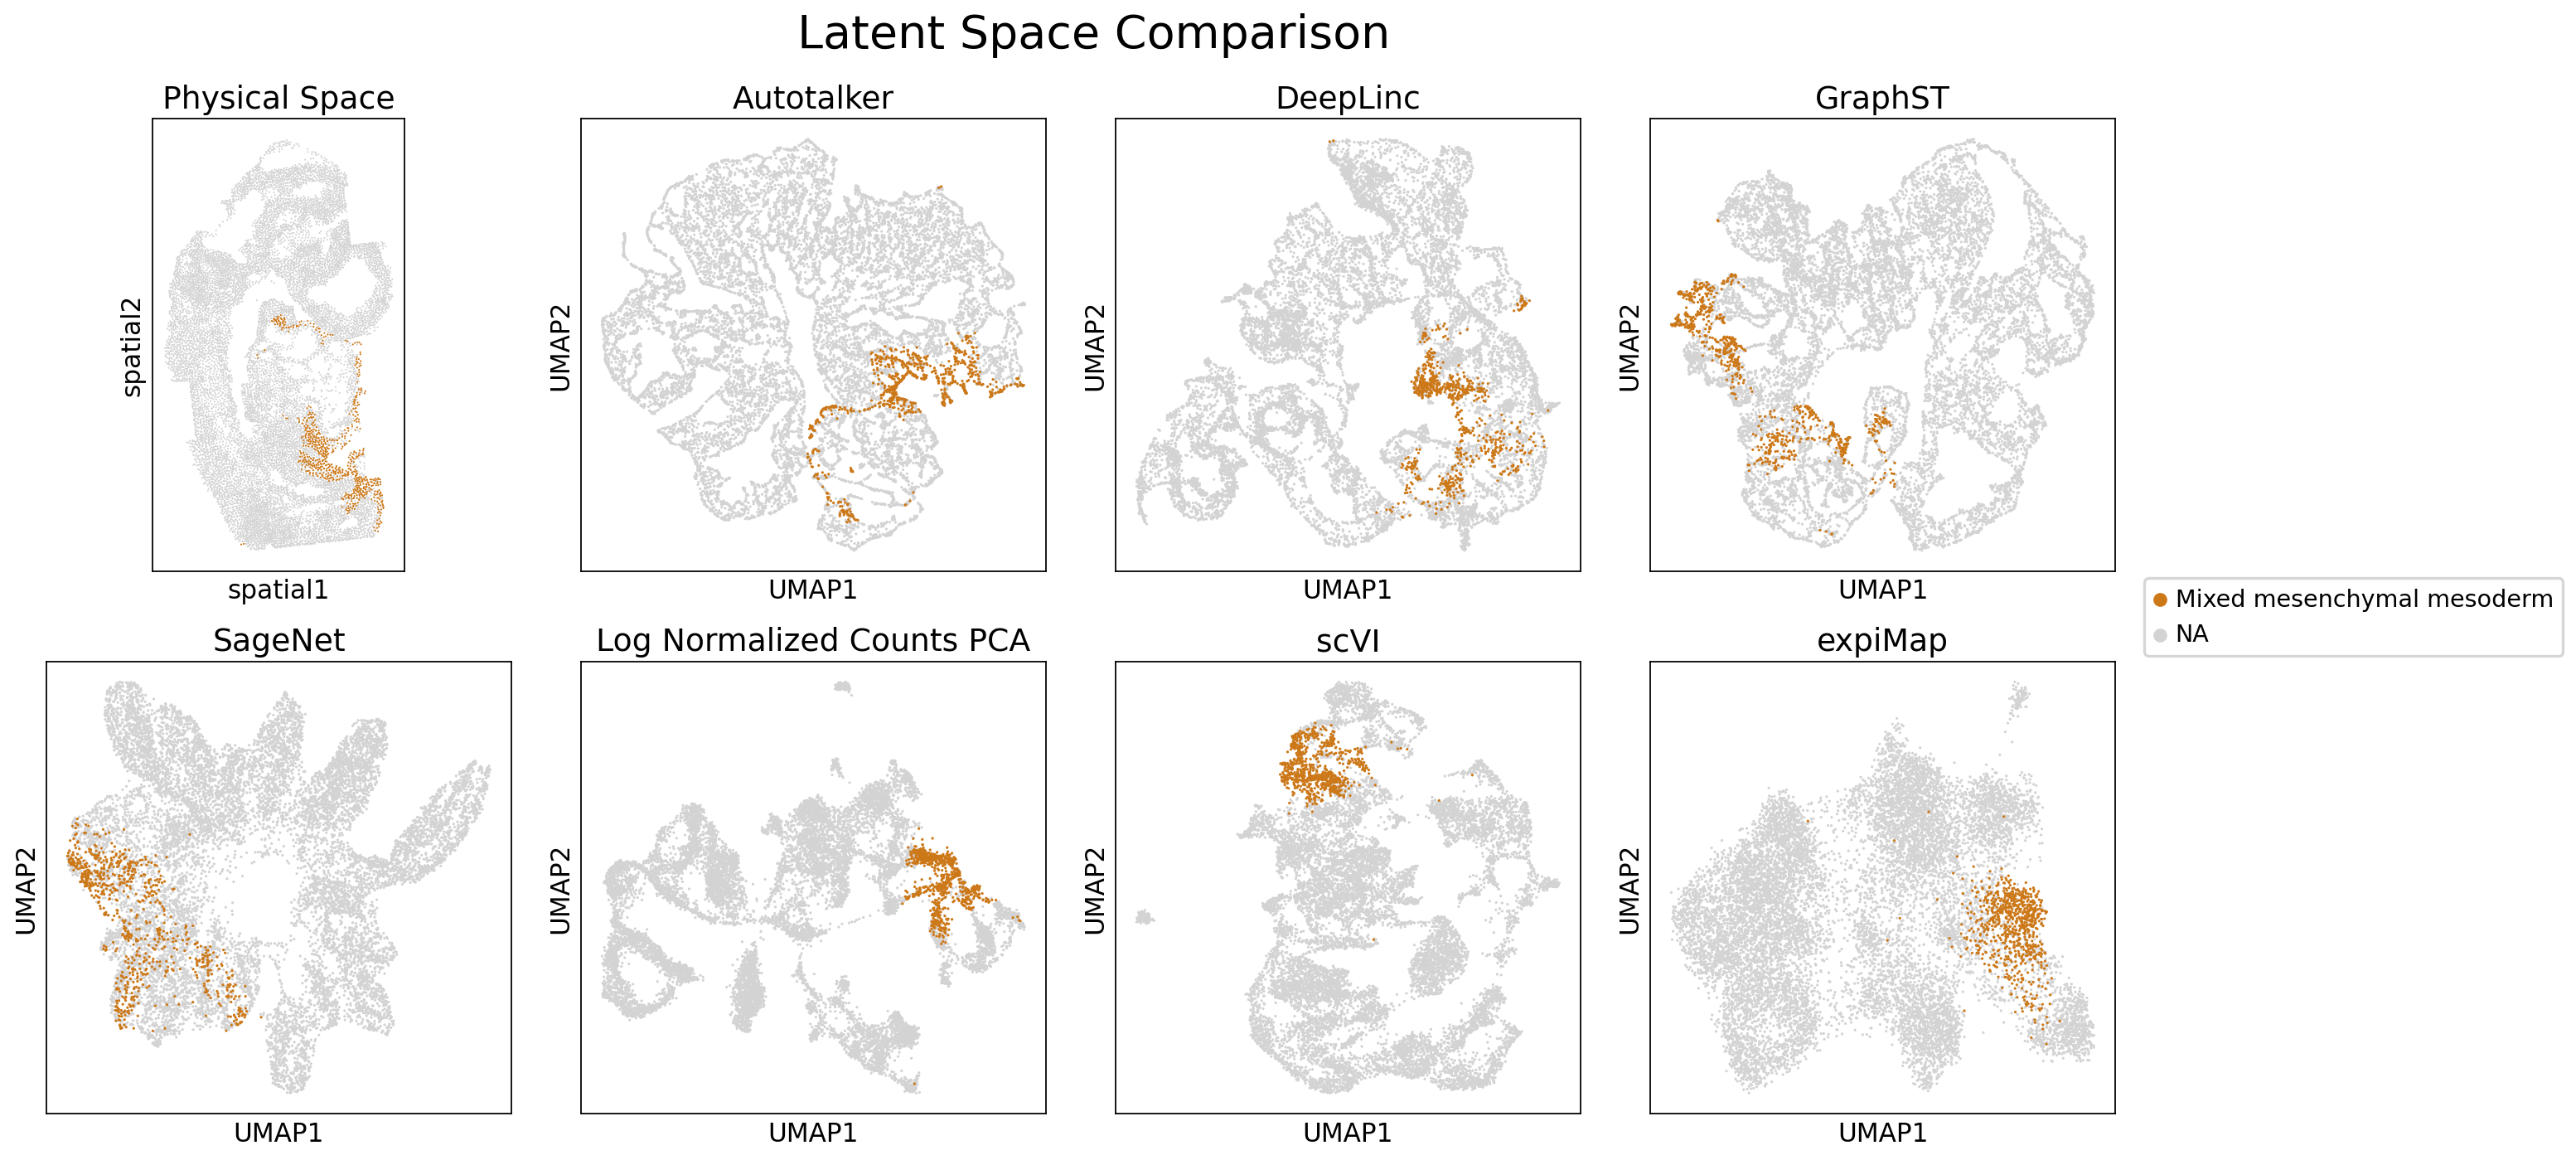

In [205]:
compute_latent_space_comparison(dataset="seqfish_mouse_organogenesis_embryo2",
                                cell_type_colors=seqfish_mouse_organogenesis_embryo2_cell_type_colors,
                                cell_type_key="celltype_mapped_refined",
                                cell_type_groups="Mixed mesenchymal mesoderm", # "Gut tube", None
                                n_neighbors=12,
                                run_number=5)

In [ ]:
compute_latent_space_comparison(dataset="seqfish_mouse_organogenesis_embryo2",
                                cell_type_key="celltype_mapped_refined",
                                cell_type_groups=None,
                                n_neighbors=12,
                                run_number=5)

In [20]:
compute_latent_space_comparison(dataset="vizgen_merfish_mouse_liver_sample",
                                cell_type_colors=vizgen_merfish_mouse_liver_cell_type_colors,
                                n_neighbors=12,
                                run_number=5)

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../../datasets/srt_data/gold/vizgen_merfish_mouse_liver_sample_deeplinc.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sebastian.birk/.conda/envs/autota

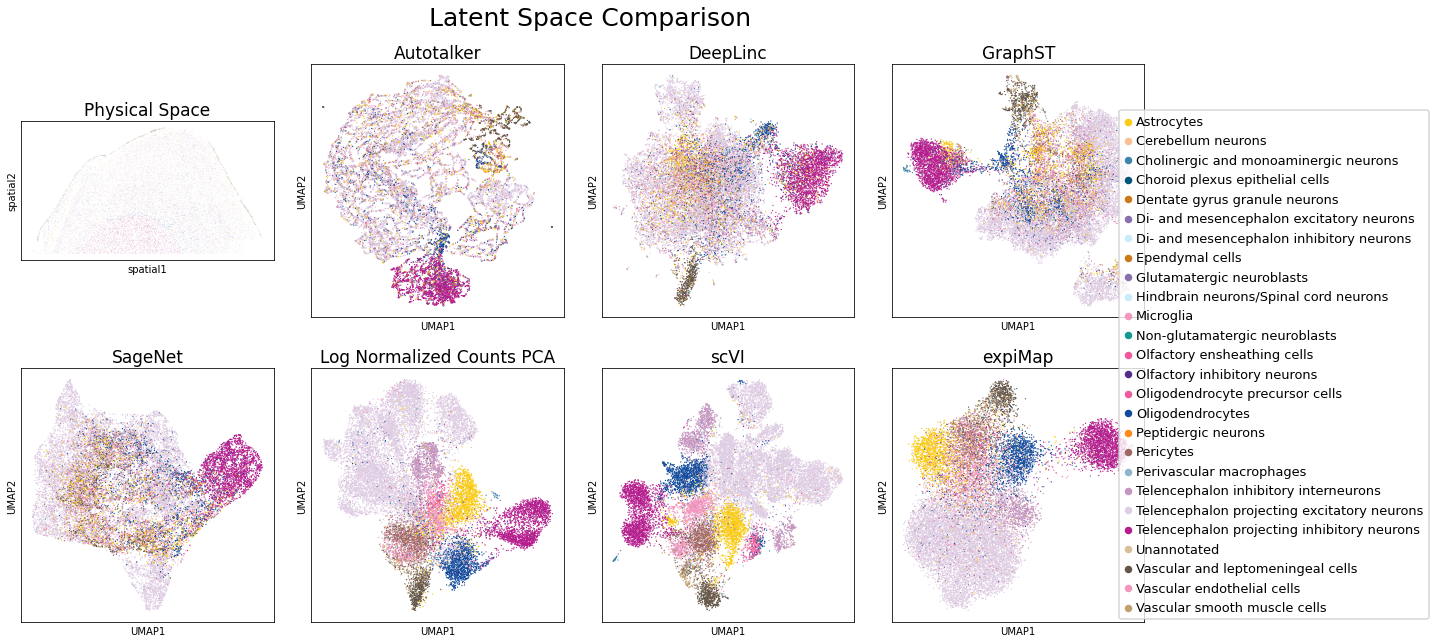

In [53]:
compute_latent_space_comparison(dataset="starmap_plus_mouse_cns_sample",
                                cell_type_colors=starmap_pluse_mouse_cns_cell_type_colors,
                                n_neighbors=12,
                                run_number=5)

In [ ]:
compute_latent_space_comparison(dataset="starmap_plus_mouse_cns",
                                cell_type_key="Main_molecular_cell_type",
                                n_neighbors=12,
                                run_number=5)

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/sebastian.birk/.conda/

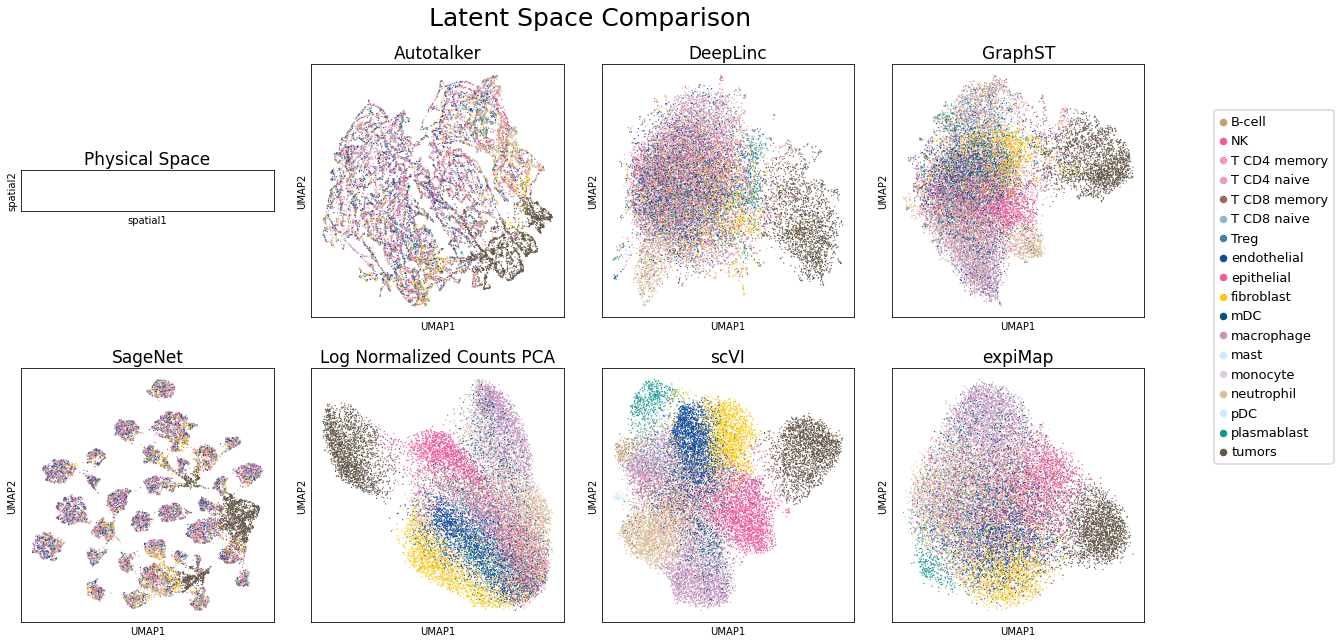

In [19]:
compute_latent_space_comparison(dataset="nanostring_cosmx_human_nsclc_sample",
                                cell_type_colors=nanostring_cosmx_human_nsclc_cell_type_colors,
                                n_neighbors=12,
                                run_number=5)

In [ ]:
compute_latent_space_comparison(dataset="nanostring_cosmx_human_nsclc",
                                cell_type_key="cell_type",
                                n_neighbors=12,
                                run_number=5)

### 3.2 Benchmarking Metrics

#### 3.2.1 Define Functions

In [11]:
def compute_combined_benchmarking_metrics(model_adata,
                                          model_name,
                                          cell_type_key="cell_type",
                                          run_number_list=list(np.arange(1, 11)),
                                          n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                          ger_genes=None):
    benchmarking_dict_list = []
    for run_number, n_neighbors in zip(run_number_list, n_neighbors_list):
        
        # Compute Autotalker metrics
        benchmarking_dict = compute_benchmarking_metrics(adata=model_adata,
                                                         latent_key=f"{model_name}_latent_run{run_number}",
                                                         cell_type_key=cell_type_key,
                                                         spatial_key=spatial_key,
                                                         spatial_knng_key=f"spatial_{n_neighbors}nng",
                                                         latent_knng_key=f"{model_name}_latent_{n_neighbors}nng_run{run_number}",
                                                         ger_genes=ger_genes)
        benchmarking_dict["model_name"] = model_name
        benchmarking_dict["run"] = run_number
        benchmarking_dict_list.append(benchmarking_dict)
    return benchmarking_dict_list

In [12]:
def compute_combined_benchmarking_metrics_for_all_models(dataset,
                                                         cell_type_key="cell_type",
                                                         run_number_list=list(np.arange(1, 11)),
                                                         n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                                         use_only_gp_mask_target_genes_for_gene_expr_regr=True):
    # Configure dataset artifact folder path
    dataset_artifact_folder_path = f"../../artifacts/{dataset}/method_benchmarking/comparison/{current_timestamp}"
    os.makedirs(dataset_artifact_folder_path, exist_ok=True)
    
    if use_only_gp_mask_target_genes_for_gene_expr_regr:
        # Identify genes that are available in gp mask as target genes
        print("Retrieving gp mask target genes...")
        adata = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
        
        nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
            keep_target_genes_ratio=0.01,
            max_n_target_genes_per_gp=20000,
            load_from_disk=False,
            save_to_disk=False,
            file_path=nichenet_ligand_target_mx_file_path)

        omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
            min_curation_effort=0,
            load_from_disk=False,
            save_to_disk=False,
            file_path=omnipath_lr_interactions_file_path)

        mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
            dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
            species="mouse",
            genes_uppercase=True)

        # Combine gene programs into one dictionary
        combined_gp_dict = dict(nichenet_gp_dict)
        combined_gp_dict.update(omnipath_gp_dict)
        combined_gp_dict.update(mebocost_gp_dict)

        # Filter and combine gene programs
        combined_new_gp_dict = filter_and_combine_gp_dict_gps(
            gp_dict=combined_gp_dict,
            gp_filter_mode="subset", #None,
            combine_overlap_gps=True, #True,
            overlap_thresh_source_genes=0.9,
            overlap_thresh_target_genes=0.9,
            overlap_thresh_genes=0.9,
            verbose=True)

        # Add the gene program dictionary as binary masks to the adata for model training
        add_gps_from_gp_dict_to_adata(
            gp_dict=combined_new_gp_dict,
            adata=adata,
            genes_uppercase=True,
            gp_targets_mask_key="autotalker_gp_targets",
            gp_sources_mask_key="autotalker_gp_sources",
            gp_names_key="autotalker_gp_names",
            min_genes_per_gp=1,
            min_source_genes_per_gp=0,
            min_target_genes_per_gp=0,
            max_genes_per_gp=None,
            max_source_genes_per_gp=None,
            max_target_genes_per_gp=None)

        ger_genes = adata.var_names[adata.uns["autotalker_target_genes_idx"]].tolist()
        del(adata)
    else:
        ger_genes = None
        
    # PCA
    print("Computing metrics for PCA...")
    adata_pca = sc.read_h5ad(data_folder_path + f"{dataset}_pca.h5ad")
    benchmarking_dict_list_pca = compute_combined_benchmarking_metrics(model_adata=adata_pca,
                                                                       model_name="pca",
                                                                       run_number_list=run_number_list,
                                                                       n_neighbors_list=n_neighbors_list,
                                                                       cell_type_key=cell_type_key,
                                                                       ger_genes=ger_genes)   
    
    benchmarking_dict_list = benchmarking_dict_list_pca
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_pca)
    print("")
    
    # scVI
    print("Computing metrics for scVI...")
    adata_scvi = sc.read_h5ad(data_folder_path + f"{dataset}_scvi.h5ad")
    benchmarking_dict_list_scvi = compute_combined_benchmarking_metrics(model_adata=adata_scvi,
                                                                        model_name="scvi",
                                                                        run_number_list=run_number_list,
                                                                        n_neighbors_list=n_neighbors_list,
                                                                        cell_type_key=cell_type_key,
                                                                        ger_genes=ger_genes)  
    benchmarking_dict_list += benchmarking_dict_list_scvi
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_scvi)
    print("")
    
    # expiMap
    print("Computing metrics for expiMap...")
    adata_expimap = sc.read_h5ad(data_folder_path + f"{dataset}_expimap.h5ad")
    benchmarking_dict_list_expimap = compute_combined_benchmarking_metrics(model_adata=adata_expimap,
                                                                           model_name="expimap",
                                                                           run_number_list=run_number_list,
                                                                           n_neighbors_list=n_neighbors_list,
                                                                           cell_type_key=cell_type_key,
                                                                           ger_genes=ger_genes)  
    benchmarking_dict_list += benchmarking_dict_list_expimap
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_expimap)
    print("")
    
    # SageNet
    print("Computing metrics for SageNet...")
    adata_sagenet = sc.read_h5ad(data_folder_path + f"{dataset}_sagenet.h5ad")
    benchmarking_dict_list_sagenet = compute_combined_benchmarking_metrics(model_adata=adata_sagenet,
                                                                           model_name="sagenet",
                                                                           run_number_list=run_number_list,
                                                                           n_neighbors_list=n_neighbors_list,
                                                                           cell_type_key=cell_type_key,
                                                                           ger_genes=ger_genes) 
    benchmarking_dict_list += benchmarking_dict_list_sagenet
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_sagenet)
    print("")
    
    # DeepLinc
    print("Computing metrics for DeepLinc...")
    adata_deeplinc = sc.read_h5ad(data_folder_path + f"{dataset}_deeplinc.h5ad")
    benchmarking_dict_list_deeplinc = compute_combined_benchmarking_metrics(model_adata=adata_deeplinc,
                                                                            model_name="deeplinc",
                                                                            run_number_list=run_number_list,
                                                                            n_neighbors_list=n_neighbors_list,
                                                                            cell_type_key=cell_type_key,
                                                                            ger_genes=ger_genes)
    benchmarking_dict_list += benchmarking_dict_list_deeplinc
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_deeplinc)
    print("")
    
    # GraphST
    print("Computing metrics for GraphST...")
    adata_graphst = sc.read_h5ad(data_folder_path + f"{dataset}_graphst.h5ad")
    benchmarking_dict_list_graphst = compute_combined_benchmarking_metrics(model_adata=adata_graphst,
                                                                           model_name="graphst",
                                                                           run_number_list=run_number_list,
                                                                           n_neighbors_list=n_neighbors_list,
                                                                           cell_type_key=cell_type_key,
                                                                           ger_genes=ger_genes)
    benchmarking_dict_list += benchmarking_dict_list_graphst
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_graphst)
    print("")
    
    # Autotalker
    print("Computing metrics for Autotalker...")
    adata_autotalker = sc.read_h5ad(data_folder_path + f"{dataset}_autotalker.h5ad")
    benchmarking_dict_list_autotalker = compute_combined_benchmarking_metrics(model_adata=adata_autotalker,
                                                                              model_name="autotalker",
                                                                              run_number_list=run_number_list,
                                                                              n_neighbors_list=n_neighbors_list,
                                                                              cell_type_key=cell_type_key,
                                                                              ger_genes=ger_genes)
    benchmarking_dict_list += benchmarking_dict_list_autotalker
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_autotalker)
    print("")

In [13]:
def create_summary_plot(dataset):
    # Read complete benchmarking data from disk
    with open(f"{artifact_folder_path}/benchmarking_dict_list.pickle", "rb") as f:
        benchmarking_dict_list = pickle.load(f)
        
    df = pd.DataFrame(benchmarking_dict_list)

#### 3.2.2 Run Functions

In [101]:
compute_combined_benchmarking_metrics_for_all_models(dataset="seqfish_mouse_organogenesis_embryo2",
                                                     cell_type_key="celltype_mapped_refined")

Retrieving gp mask target genes...
Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


493.5475538177342
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


492.4906321731881
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


492.9505855385374
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


492.9322549607962
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


493.78650362569215
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


492.98117119571316
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


493.43740160725156
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


492.56486581714444
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


493.47359348512856
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


492.8620702624962
Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for scVI...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


488.91366105059507
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


500.5947935867778
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


490.06078176516667
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


489.7943470415343
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


507.3092255048466
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


499.7134318974363
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


494.1156023922665
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


484.09862883334995
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


501.3806408164547
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


500.41878044173285
Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for expiMap...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


546.9360860790147
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


522.9445021055642
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


521.1489450362113
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


543.7711611892092
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


542.0065082958512
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


517.4456526786613
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


525.2632343595603
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


514.0090964761208
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


519.4873436439317
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


515.2549877010646
Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for SageNet...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


247.22893586835
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


240.25244600163893
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


267.8886774790326
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


258.8726807780733
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


316.5952478166367
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


319.75418354850143
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


321.332733470084
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


313.4891223645581
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


334.7285056398724
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


333.72706854629945
Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for DeepLinc...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


263.6069117085311
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


209.27507167077962
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


176.83853667653347
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


147.05476446417794
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


130.96333743497206
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


124.40205129076449
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


129.86366652490392
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


130.28105884436096
Computing CLISIS...
Computing GERR2...
Computing CCA...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


109.81416480393982
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


137.52698305769928
Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for GraphST...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


244.42334232221546
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


229.58915468067764
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


190.2965194334056
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


196.47993303070876
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


188.16025925048024
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


183.95024057896822
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


180.18798071434728
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


187.0276580956421
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


190.78583004118568
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


192.11659452770434
Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for Autotalker...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


196.93298416494008
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


201.5065468476908
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


138.57367601767274
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


139.075122997808
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


89.83939657654017
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


82.05569825474018
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


64.54054077279652
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


58.76824439407831
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


52.390119894899826
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


61.19779120825672
Computing CLISIS...
Computing GERR2...
Computing CCA...



In [ ]:
compute_combined_benchmarking_metrics_for_all_models(dataset="vizgen_merfish_mouse_liver",
                                                     cell_type_key="Cell_Type",)

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(dataset="starmap_plus_mouse_cns")

Retrieving gp mask target genes...


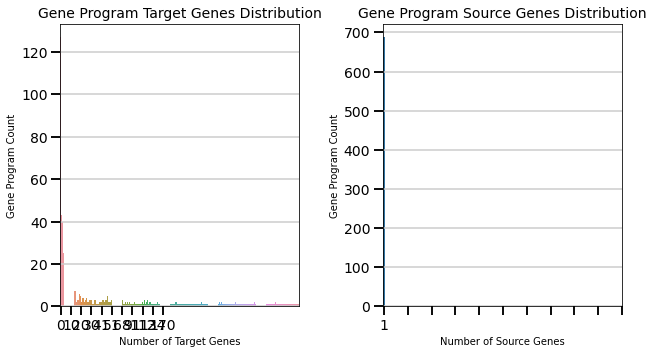

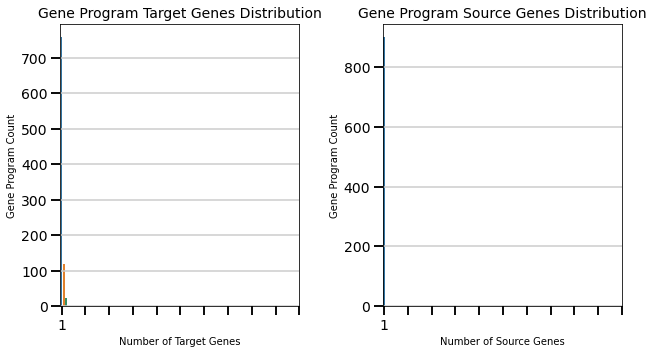

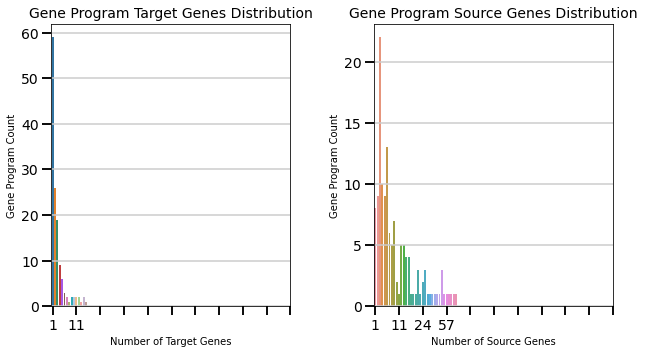

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for scVI...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for expiMap...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for SageNet...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for DeepLinc...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for GraphST...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for Autotalker...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Computing CLISIS...
Computing GERR2...
Computing CCA...



In [14]:
compute_combined_benchmarking_metrics_for_all_models(dataset="starmap_plus_mouse_cns_sample")

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(dataset="nanostring_cosmx_human_nsclc",
                                                     cell_type_key="cell_type")

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(dataset="nanostring_cosmx_human_nsclc_sample")

#### 3.2.8 Summary

In [100]:
df = pd.DataFrame()
datasets = [#"seqfish_mouse_organogenesis_embryo2",
            "starmap_plus_mouse_cns_sample",
            "nanostring_cosmx_human_nsclc_sample"]
timestamps = [#"24022023_115320",
              "07032023_071219",
              "07032023_080409"]

for dataset, timestamp in zip(datasets, timestamps):
    dataset_artifact_folder_path = f"../../artifacts/{dataset}/method_benchmarking/comparison/{timestamp}"
    
    # Read complete benchmarking data from disk
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "rb") as f:
        benchmarking_dict_list = pickle.load(f)
        dataset_df = pd.DataFrame(benchmarking_dict_list)
        dataset_df["dataset"] = dataset
        df = pd.concat([df, dataset_df])
df.head()

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


gcs    mlami       cas    clisis  gerr2       cca model_name  run  \
0  0.759691  0.25785  0.521754  0.813523    1.0  0.905205        pca    1   
1  0.759691  0.25785  0.521754  0.813523    1.0  0.905205        pca    2   
2  0.759691  0.25785  0.521754  0.813523    1.0  0.905205        pca    3   
3  0.759691  0.25785  0.521754  0.813523    1.0  0.905205        pca    4   
4  0.759691  0.25785  0.521754  0.813523    1.0  0.905205        pca    5   

                         dataset  
0  starmap_plus_mouse_cns_sample  
1  starmap_plus_mouse_cns_sample  
2  starmap_plus_mouse_cns_sample  
3  starmap_plus_mouse_cns_sample  
4  starmap_plus_mouse_cns_sample

In [101]:
columns = ["gcs",
           "mlami",
           "cas",
           "clisis",
           #"gerr2",
           #"cca"
           ]

rows = ["autotalker",
        "deeplinc",
        "graphst",
        "sagenet",
        "pca",
        "scvi",
        "expimap"]

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
unrolled_df = pd.melt(df, 
   id_vars = ["model_name", "dataset"],
   value_vars = columns,
   var_name = "score_type", 
   value_name = "score")

In [134]:
# Compute metric means over all runs
mean_df = unrolled_df.groupby(["model_name", "dataset", "score_type"]).mean()

# mean_df = mean_df[columns]
# mean_df = mean_df.reindex(rows)
# mean_df["model_name"] = mean_df.index.get_level_values(0)
# mean_df["dataset"] = mean_df.index.get_level_values(1)
# mean_df["score_type"] = mean_df.index.get_level_values(2)

In [ ]:
# Compute metric means over all runs
mean_df = df.groupby("model_name").mean()

mean_df = mean_df[columns]
mean_df = mean_df.reindex(rows)

metric_ranks = []
for metric in mean_df.columns:
    mean_df[f"{metric}_rank"] = mean_df[metric].rank(ascending=False).astype(int)

mean_df["model_name"] = mean_df.index

unrolled_mean_df = pd.melt(mean_df, 
   id_vars = ["model_name"],
   value_vars = columns,
   var_name = "score_type", 
   value_name = "score")

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-50-349145aa4b13>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df.groupby("model_name").mean()


In [124]:
mean_df

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


score  \
model_name dataset                             score_type             
autotalker nanostring_cosmx_human_nsclc_sample cas         0.879017   
                                               clisis      0.913269   
                                               gcs         0.937944   
                                               mlami       0.670736   
           starmap_plus_mouse_cns_sample       cas         0.932764   
                                               clisis      0.915092   
                                               gcs         0.935180   
                                               mlami       0.691804   
deeplinc   nanostring_cosmx_human_nsclc_sample cas         0.582458   
                                               clisis      0.915609   
                                               gcs         0.820074   
                                               mlami       0.303944   
           starmap_plus_mouse_cns_sample       cas         0.787031   
                                               clisis      0.909646   
                                               gcs         0.844062   
                                               mlami       0.499728   
expimap    nanostring_cosmx_human_nsclc_sample cas         0.528699   
                                               clisis      0.897808   
                                               gcs         0.748459   
                                               mlami       0.086340   
           starmap_plus_mouse_cns_sample       cas         0.725434   
                                               clisis      0.869889   
                                               gcs         0.751896   
                                               mlami       0.202655   
graphst    nanostring_cosmx_human_nsclc_sample cas         0.660430   
                                               clisis      0.879940   
                                               gcs         0.886351   
                                               mlami       0.271898   
           starmap_plus_mouse_cns_sample       cas         0.687373   
                                               clisis      0.871559   
                                               gcs         0.883339   
                                               mlami       0.487869   
pca        nanostring_cosmx_human_nsclc_sample cas         0.465104   
                                               clisis      0.834088   
                                               gcs         0.756214   
                                               mlami       0.107750   
           starmap_plus_mouse_cns_sample       cas         0.521754   
                                               clisis      0.813523   
                                               gcs         0.759691   
                                               mlami       0.257850   
sagenet    nanostring_cosmx_human_nsclc_sample cas         0.693923   
                                               clisis      0.906098   
                                               gcs         0.758835   
                                               mlami       0.116844   
           starmap_plus_mouse_cns_sample       cas         0.792529   
                                               clisis      0.850154   
                                               gcs         0.761723   
                                               mlami       0.361273   
scvi       nanostring_cosmx_human_nsclc_sample cas         0.288625   
                                               clisis      0.760188   
                                               gcs         0.760527   
                                               mlami       0.112456   
           starmap_plus_mouse_cns_sample       cas         0.442096   
                                               clisis      0.812650   
                                               gcs         0.764513   
               

In [247]:
mean_df = unrolled_df.groupby(["model_name", "dataset", "score_type"]).mean()
mean_df.reset_index(inplace=True)


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [264]:
mean_df_pivot

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model_name  nanostring_cosmx_human_nsclc_sample_cas  \
0  autotalker                                 0.879017   
1    deeplinc                                 0.582458   
2     expimap                                 0.528699   
3     graphst                                 0.660430   
4         pca                                 0.465104   
5     sagenet                                 0.693923   
6        scvi                                 0.288625   

   nanostring_cosmx_human_nsclc_sample_clisis  \
0                                    0.913269   
1                                    0.915609   
2                                    0.897808   
3                                    0.879940   
4                                    0.834088   
5                                    0.906098   
6                                    0.760188   

   nanostring_cosmx_human_nsclc_sample_gcs  \
0                                 0.937944   
1                                 0.820074   
2                                 0.748459   
3                                 0.886351   
4                                 0.756214   
5                                 0.758835   
6                                 0.760527   

   nanostring_cosmx_human_nsclc_sample_mlami  \
0                                   0.670736   
1                                   0.303944   
2                                   0.086340   
3                                   0.271898   
4                                   0.107750   
5                                   0.116844   
6                                   0.112456   

   starmap_plus_mouse_cns_sample_cas  starmap_plus_mouse_cns_sample_clisis  \
0                           0.932764                              0.915092   
1                           0.787031                              0.909646   
2                           0.725434                              0.869889   
3                           0.687373                              0.871559   
4                           0.521754                              0.813523   
5                           0.792529                              0.850154   
6                           0.442096                              0.812650   

   starmap_plus_mouse_cns_sample_gcs  starmap_plus_mouse_cns_sample_mlami  
0                           0.935180                             0.691804  
1                           0.844062                             0.499728  
2                           0.751896                             0.202655  
3                           0.883339                             0.487869  
4                           0.759691                             0.257850  
5                           0.761723                             0.361273  
6                           0.764513                             0.263573

In [275]:
mean_df_pivot = mean_df.pivot(index=['model_name'], columns=["dataset", "score_type"], values="score")
mean_df_pivot.reset_index(inplace=True)
mean_df_pivot.columns = ['_'.join(col).strip("_") for col in mean_df_pivot.columns.values]

['starmap_plus_mouse_cns_sample_mlami',
 'nanostring_cosmx_human_nsclc_sample_clisis',
 'nanostring_cosmx_human_nsclc_sample_cas',
 'starmap_plus_mouse_cns_sample_cas',
 'nanostring_cosmx_human_nsclc_sample_mlami',
 'nanostring_cosmx_human_nsclc_sample_gcs',
 'starmap_plus_mouse_cns_sample_gcs',
 'starmap_plus_mouse_cns_sample_clisis']

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [314]:
mean_df_pivot
dataset = "nanostring_cosmx_human_nsclc_sample"

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [320]:
list(mean_df_pivot.columns)

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['model_name',
 'nanostring_cosmx_human_nsclc_sample_cas',
 'nanostring_cosmx_human_nsclc_sample_clisis',
 'nanostring_cosmx_human_nsclc_sample_gcs',
 'nanostring_cosmx_human_nsclc_sample_mlami',
 'starmap_plus_mouse_cns_sample_cas',
 'starmap_plus_mouse_cns_sample_clisis',
 'starmap_plus_mouse_cns_sample_gcs',
 'starmap_plus_mouse_cns_sample_mlami',
 'Total']

In [322]:
[col for col in list(mean_df_pivot.columns) if dataset in col]

['nanostring_cosmx_human_nsclc_sample_cas',
 'nanostring_cosmx_human_nsclc_sample_clisis',
 'nanostring_cosmx_human_nsclc_sample_gcs',
 'nanostring_cosmx_human_nsclc_sample_mlami']

nanostring_cosmx_human_nsclc_sample_cas  \
0                                 0.879017   
1                                 0.582458   
2                                 0.528699   
3                                 0.660430   
4                                 0.465104   
5                                 0.693923   
6                                 0.288625   

   nanostring_cosmx_human_nsclc_sample_clisis  \
0                                    0.913269   
1                                    0.915609   
2                                    0.897808   
3                                    0.879940   
4                                    0.834088   
5                                    0.906098   
6                                    0.760188   

   nanostring_cosmx_human_nsclc_sample_gcs  \
0                                 0.937944   
1                                 0.820074   
2                                 0.748459   
3                                 0.886351   
4                                 0.756214   
5                                 0.758835   
6                                 0.760527   

   nanostring_cosmx_human_nsclc_sample_mlami  
0                                   0.670736  
1                                   0.303944  
2                                   0.086340  
3                                   0.271898  
4                                   0.107750  
5                                   0.116844  
6                                   0.112456

In [445]:
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
from plottable.formatters import tickcross

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plot_benchmarking_results(df, show=True, save_dir=None):
    datasets = df["dataset"].unique().tolist()
    df = df.pivot(index=["model_name", "spatially_aware"], columns=["dataset", "score_type"], values="score")
    df.reset_index(inplace=True)
    df.columns = ['_'.join(col).strip("_") for col in df.columns.values]
    if len(datasets) > 1:
        for i, dataset in enumerate(datasets):
            df[f"Total ({i})"] = df[[col for col in list(df.columns) if dataset in col]].mean(axis=1)
        df["Total (All)"] = df[list(set(list(df.columns)) - set(["model_name", "spatially_aware"]))].mean(axis=1)
        df.sort_values(by=["Total (All)"], inplace=True, ascending=False)
    else:
        df["Total"] = df[list(set(list(df.columns)) - set(["model_name"]))].mean(axis=1)
        df.sort_values(by=["Total"], inplace=True, ascending=False)
    df.rename(columns={"model_name": "Model"}, inplace=True)
    
    display(df.head())
    
    cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)

    column_definitions = [
        ColumnDefinition(name="Model",
                         title="Model",
                         width=1.5,
                         textprops={"ha": "left", "weight": "bold"}),
        ColumnDefinition(name="spatially_aware",
                         title="Spatially \n Aware",
                         width=1.,
                         formatter=tickcross)]

    metric_cols = ["cas", "clisis", "gcs", "mlami"]
    aggregate_cols = [col for col in list(df.columns) if "Total" in col]

    for i, dataset in enumerate(datasets):
        if len(datasets) > 1:
            dataset_number_string = f"({i})"
        else:
            dataset_number_string = ""
        # Circles for the metric columns
        column_definitions += [
            ColumnDefinition(
                name=f"{dataset}_{col}",
                title=col.upper(),
                width=1,
                textprops={
                    "ha": "center",
                    "bbox": {"boxstyle": "circle", "pad": 0.25}},
                cmap=cmap_fn(df[f"{dataset}_{col}"]),
                group=f"Metrics \n {dataset.replace('_', ' ').title()} {dataset_number_string}",
                border="left" if j == 0 else None,
                formatter="{:.2f}")
            for j, col in enumerate(metric_cols)]

        # Bars for the aggregate columns
        column_definitions += [
            ColumnDefinition(
                name=col,
                title=col,
                width=1,
                plot_fn=bar,
                plot_kw={
                    "cmap": truncate_colormap(matplotlib.cm.YlOrRd, 0, 0.8),
                    "plot_bg_bar": False,
                    "annotate": True,
                    "height": 0.9,
                    "formatter": "{:.2f}",
                },
                group="Aggregate Scores",
                border="left" if j == 0 else None)
            for j, col in enumerate(aggregate_cols)]
        
    # Allow to manipulate text post-hoc (in illustrator)
    with matplotlib.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(figsize=(len(df.columns) * 1., 3 + 0.3 * len(df.columns)))
        tab = Table(
            df,
            cell_kw={
                "linewidth": 0,
                "edgecolor": "k",
            },
            column_definitions=column_definitions,
            ax=ax,
            row_dividers=True,
            footer_divider=True,
            textprops={"fontsize": 10, "ha": "center"},
            row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 1, "linestyle": "-"},
            index_col="Model",
        ).autoset_fontcolors(colnames=df.columns)
            
    if show:
        plt.show()
    if save_dir is not None:
        fig.savefig(os.path.join(save_dir, "scib_results.svg"), facecolor=ax.get_facecolor(), dpi=300)

    return tab

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [448]:
# df = mean_df[(mean_df["model_name"] != "pca") & (mean_df["dataset"] == "starmap_plus_mouse_cns_sample")]
df = mean_df

In [449]:
df = df[df["model_name"] != "pca"]

df.replace({"autotalker": "Autotalker",
            "deeplinc": "DeepLinc",
            "expimap": "expiMap",
            "graphst": "GraphST",
            "sagenet": "SageNet",
            "scvi": "scVI",
            "nanostring_cosmx_human_nsclc_sample": "nanostring_cosmx_sample",
            "starmap_plus_mouse_cns_sample": "starmap_plus_sample"}, inplace=True)

def is_spatially_aware_model(row):
    if row["model_name"] in ["Autotalker", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False

df["spatially_aware"] = df.apply(lambda row: is_spatially_aware_model(row), axis=1)

<ipython-input-449-20c55086408c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace({"autotalker": "Autotalker",
<ipython-input-449-20c55086408c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["spatially_aware"] = df.apply(lambda row: is_spatially_aware_model(row), axis=1)


In [447]:
df = df[df["dataset"] == "starmap_plus_sample"]

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model  spatially_aware  nanostring_cosmx_sample_cas  \
0  Autotalker             True                     0.879017   
1    DeepLinc             True                     0.582458   
2     GraphST             True                     0.660430   
3     SageNet             True                     0.693923   
4     expiMap            False                     0.528699   

   nanostring_cosmx_sample_clisis  nanostring_cosmx_sample_gcs  \
0                        0.913269                     0.937944   
1                        0.915609                     0.820074   
2                        0.879940                     0.886351   
3                        0.906098                     0.758835   
4                        0.897808                     0.748459   

   nanostring_cosmx_sample_mlami  starmap_plus_sample_cas  \
0                       0.670736                 0.932764   
1                       0.303944                 0.787031   
2                       0.271898                 0.687373   
3                       0.116844                 0.792529   
4                       0.086340                 0.725434   

   starmap_plus_sample_clisis  starmap_plus_sample_gcs  \
0                    0.915092                 0.935180   
1                    0.909646                 0.844062   
2                    0.871559                 0.883339   
3                    0.850154                 0.761723   
4                    0.869889                 0.751896   

   starmap_plus_sample_mlami  Total (0)  Total (1)  Total (All)  
0                   0.691804   0.850241   0.868710     0.859476  
1                   0.499728   0.655521   0.760117     0.707819  
2                   0.487869   0.674655   0.732535     0.703595  
3                   0.361273   0.618925   0.691420     0.655173  
4                   0.202655   0.565327   0.637468     0.601397

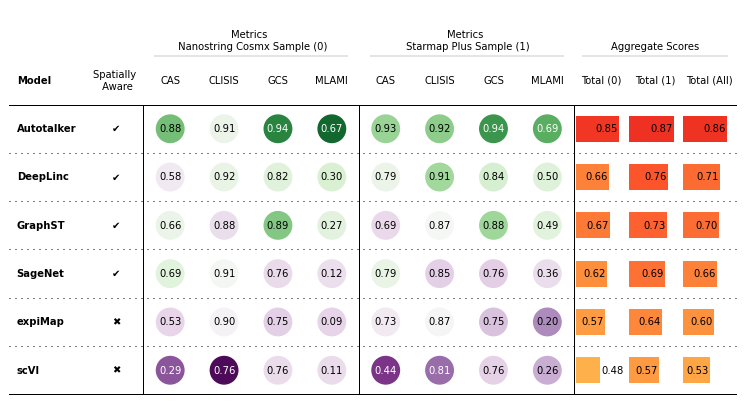

In [450]:
plot_benchmarking_results(df)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from plottable import Table

d = pd.DataFrame(np.random.random((5, 5)), columns=["A", "B", "C", "D", "E"]).round(2)
fig, ax = plt.subplots(figsize=(6, 5))
tab = Table(d)

plt.show()

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


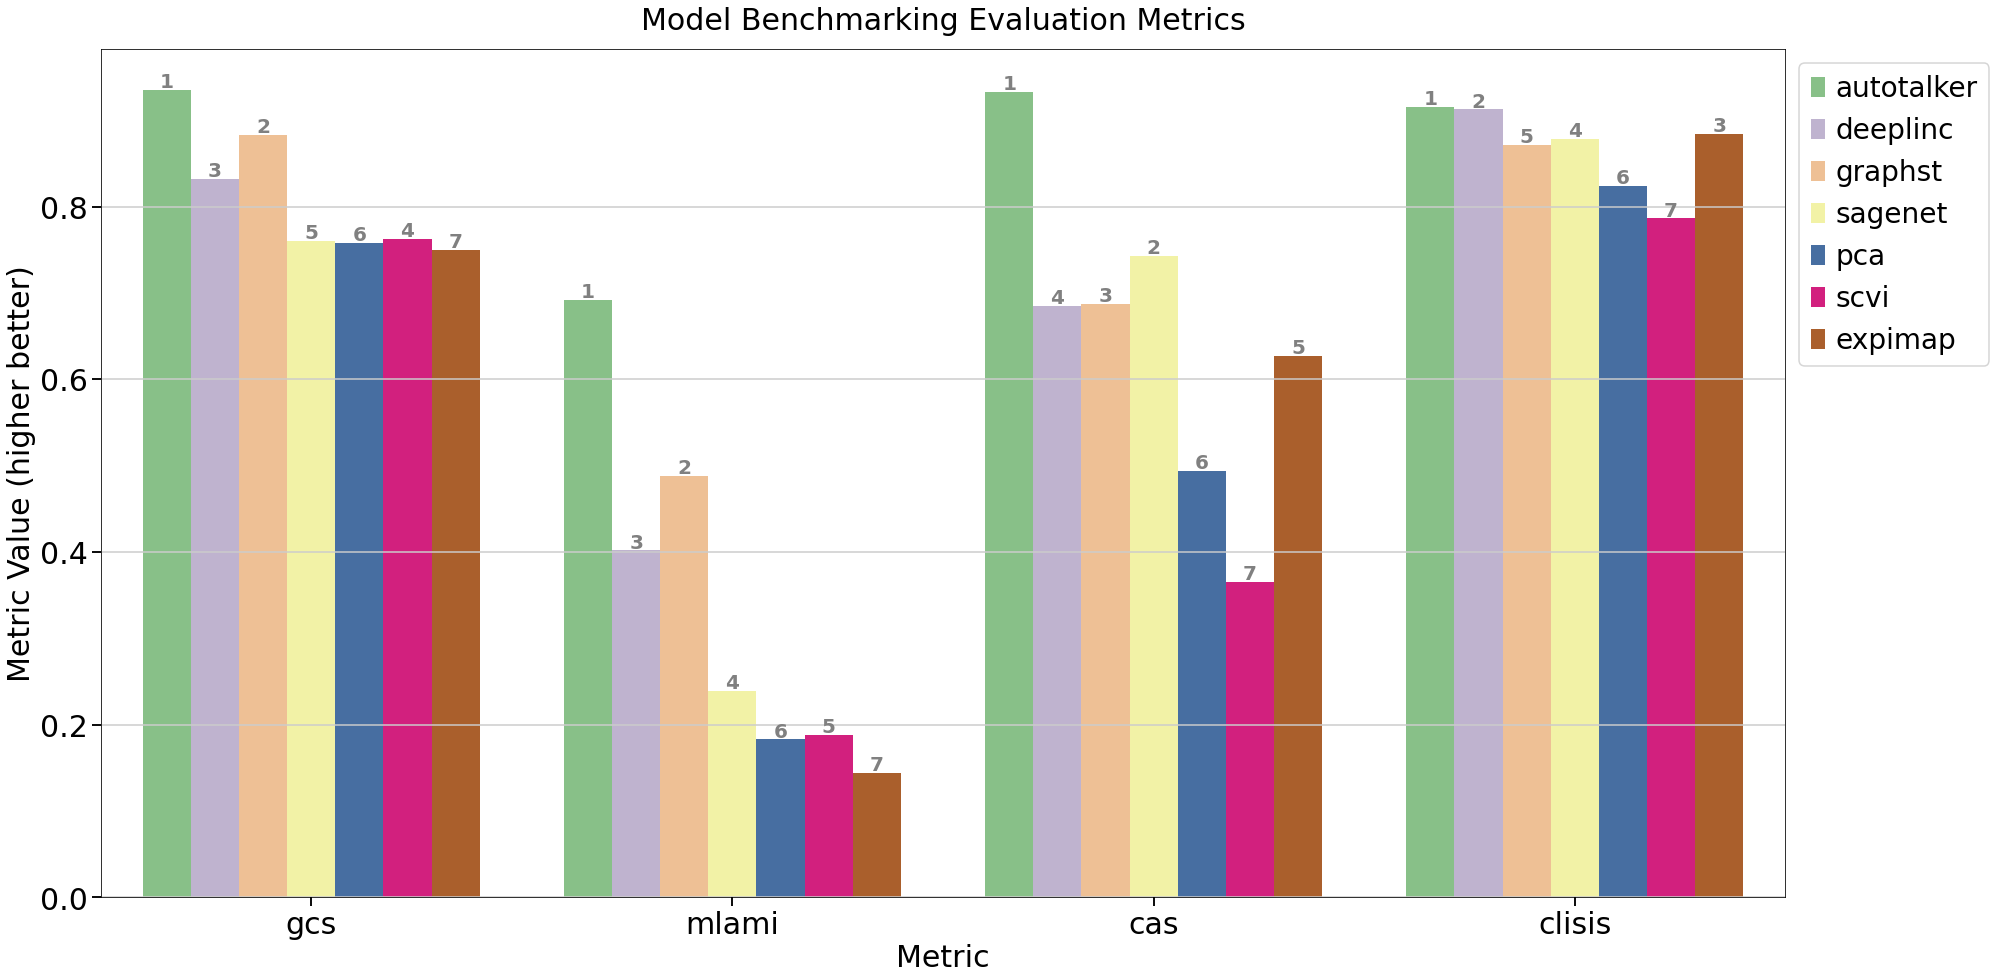

In [ ]:
plt.figure(figsize=(30, 15))
ax = sns.barplot(data=unrolled_mean_df,
                 x="score_type",
                 y="score",
                 hue="model_name",
                 palette="Accent")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Iterate over the bars and annotate each one with the rank
for i, p in enumerate(ax.patches):
    model_idx, metric_idx = divmod(i, len(columns))
    rank = mean_df.loc[rows[model_idx], columns[metric_idx] + "_rank"]
    ax.annotate("%.0f" % rank,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center",
                va="center",
                fontsize=20,
                color="gray",
                weight="bold",
                xytext=(0, 8),
                textcoords="offset points")

plt.xlabel("Metric",
           fontsize=30)
plt.ylabel("Metric Value (higher better)",
           fontsize=30)
plt.legend(loc=2,
           bbox_to_anchor=(1, 1),
           prop={"size": 28})
plt.title("Model Benchmarking Evaluation Metrics",
          fontsize=30,
          pad=20)
plt.savefig(f"{figure_folder_path}/eval_metrics.svg",
            dpi=300,
            bbox_inches="tight",
            format="svg")
plt.show()

In [109]:
mean_df["dataset_score_type"] = mean_df["score_type"] + mean_df["dataset"]

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
mean_df[mean_df["model_name"] == "autotalker"]

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


score  \
model_name dataset                             score_type             
autotalker nanostring_cosmx_human_nsclc_sample cas         0.879017   
                                               clisis      0.913269   
                                               gcs         0.937944   
                                               mlami       0.670736   
           starmap_plus_mouse_cns_sample       cas         0.932764   
                                               clisis      0.915092   
                                               gcs         0.935180   
                                               mlami       0.691804   

                                                           model_name  \
model_name dataset                             score_type               
autotalker nanostring_cosmx_human_nsclc_sample cas         autotalker   
                                               clisis      autotalker   
                                               gcs         autotalker   
                                               mlami       autotalker   
           starmap_plus_mouse_cns_sample       cas         autotalker   
                                               clisis      autotalker   
                                               gcs         autotalker   
                                               mlami       autotalker   

                                                                                       dataset  \
model_name dataset                             score_type                                        
autotalker nanostring_cosmx_human_nsclc_sample cas         nanostring_cosmx_human_nsclc_sample   
                                               clisis      nanostring_cosmx_human_nsclc_sample   
                                               gcs         nanostring_cosmx_human_nsclc_sample   
                                               mlami       nanostring_cosmx_human_nsclc_sample   
           starmap_plus_mouse_cns_sample       cas               starmap_plus_mouse_cns_sample   
                                               clisis            starmap_plus_mouse_cns_sample   
                                               gcs               starmap_plus_mouse_cns_sample   
                                               mlami             starmap_plus_mouse_cns_sample   

                                                          score_type  
model_name dataset                             score_type             
autotalker nanostring_cosmx_human_nsclc_sample cas               cas  
                                               clisis         clisis  
                                               gcs               gcs  
                                               mlami           mlami  
           starmap_plus_mouse_cns_sample       cas               cas  
                                               clisis         clisis  
                                               gcs               gcs  
                                               mlami           mlami

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


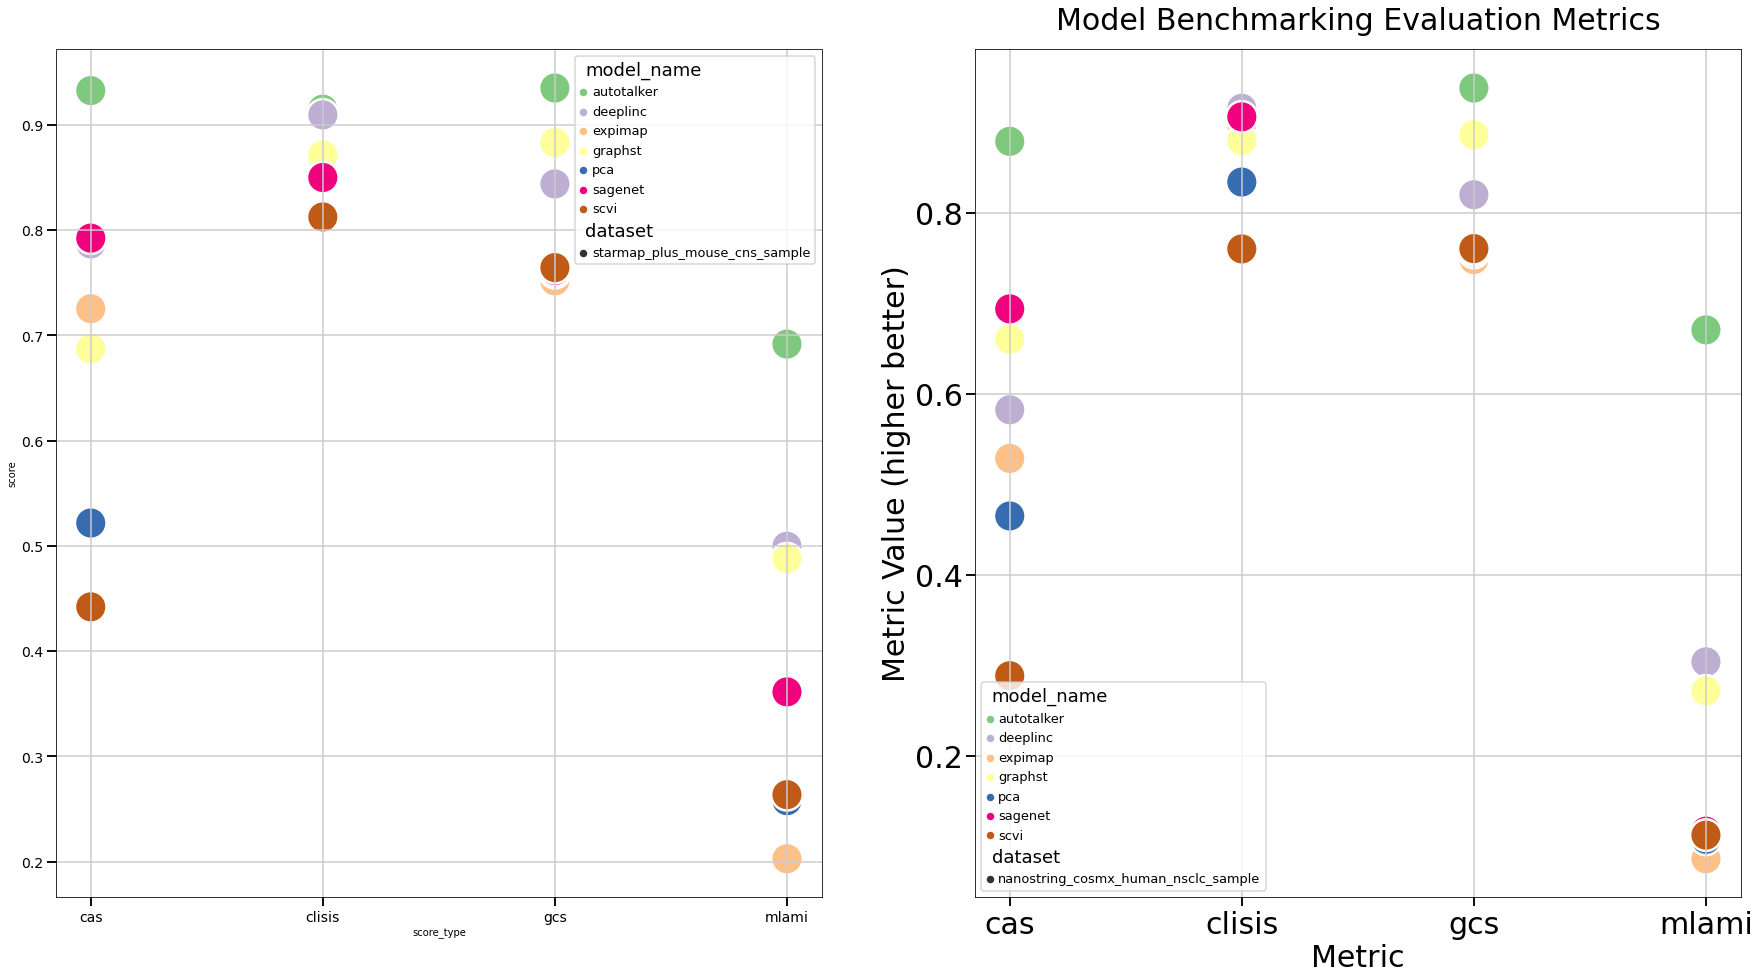

In [118]:
fig, axs = plt.subplots(ncols=2, figsize=(30, 15))

plt.xlabel("Metric",
           fontsize=30)
plt.ylabel("Metric Value (higher better)",
           fontsize=30)
plt.legend(loc=2,
           bbox_to_anchor=(1, 1),
           prop={"size": 28})
plt.title("Model Benchmarking Evaluation Metrics",
          fontsize=30,
          pad=20)

sns.scatterplot(data=mean_df[mean_df["dataset"] == "starmap_plus_mouse_cns_sample"],
                ax=axs[0],
                 x="score_type",
                 y="score",
                 hue="model_name",
                 palette="Accent",
                 s=1000,
                 style="dataset")

sns.scatterplot(data=mean_df[mean_df["dataset"] == "nanostring_cosmx_human_nsclc_sample"],
                ax=axs[1],
                 x="score_type",
                 y="score",
                 hue="model_name",
                 palette="Accent",
                 s=1000,
                 style="dataset")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)


plt.savefig(f"{figure_folder_path}/eval_metrics.svg",
            dpi=300,
            bbox_inches="tight",
            format="svg")
plt.show()

/home/sebastian.birk/.conda/envs/autotalker_hpc/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


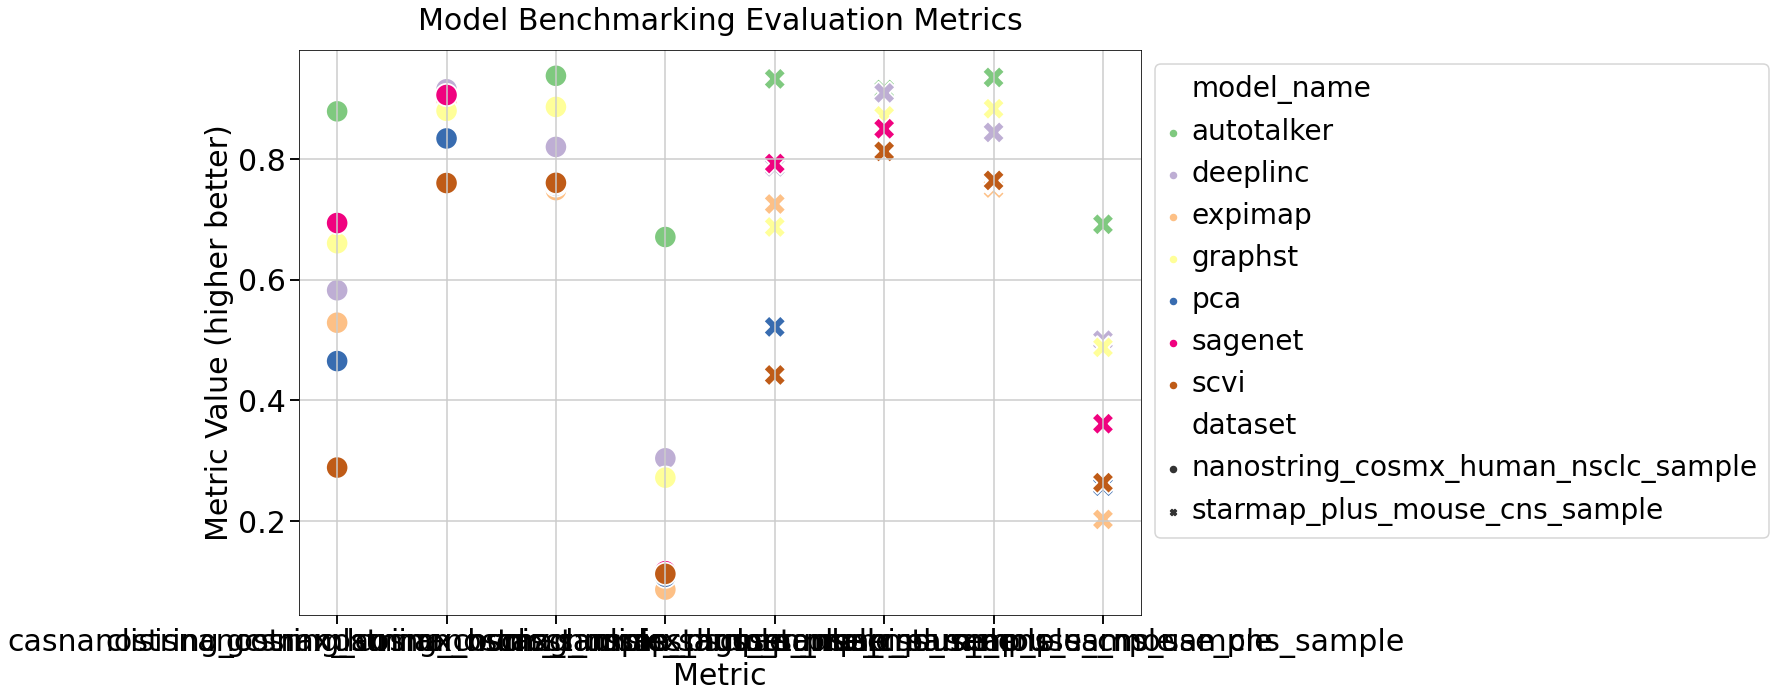

In [114]:
plt.figure(figsize=(15, 10))
ax = sns.scatterplot(data=mean_df,
                 x="dataset_score_type",
                 y="score",
                 hue="model_name",
                 palette="Accent",
                 s=500,
                 style="dataset")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Iterate over the bars and annotate each one with the rank
for i, p in enumerate(ax.patches):
    model_idx, metric_idx = divmod(i, len(columns))
    rank = mean_df.loc[rows[model_idx], columns[metric_idx] + "_rank"]
    ax.annotate("%.0f" % rank,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center",
                va="center",
                fontsize=20,
                color="gray",
                weight="bold",
                xytext=(0, 8),
                textcoords="offset points")

plt.xlabel("Metric",
           fontsize=30)
plt.ylabel("Metric Value (higher better)",
           fontsize=30)
plt.legend(loc=2,
           bbox_to_anchor=(1, 1),
           prop={"size": 28})
plt.title("Model Benchmarking Evaluation Metrics",
          fontsize=30,
          pad=20)
plt.savefig(f"{figure_folder_path}/eval_metrics.svg",
            dpi=300,
            bbox_inches="tight",
            format="svg")
plt.show()

##### 3.2.8.1 Metrics Ranking Plot

In [17]:
mean_df_min_best = mean_df[["gcd", "cad", "arclisi", "germse"]] # lower values are better
mean_df_max_best = mean_df[["mlnmi", "cca", "ari", "clisi", "nmi", "asw", "ilasw", ]] # higher values are better
rank_df_min = mean_df_min_best.rank(method="max", ascending=True)
rank_df_max = mean_df_max_best.rank(method="max", ascending=False)
rank_df = pd.concat([rank_df_min, rank_df_max], axis=1)
rank_df = rank_df[columns]

KeyError: "None of [Index(['gcd', 'cad', 'arclisi', 'germse'], dtype='object')] are in the [columns]"

In [ ]:
heatmap = sns.heatmap(rank_df, annot=True, cmap="YlGnBu")
fig = heatmap.get_figure()
plt.title("Method Benchmarking Metrics Ranking", fontsize=20, pad=25)
plt.xticks(rotation=45)
fig.savefig(f"{figure_folder_path}/metrics_ranking_{current_timestamp}.png",
            bbox_inches="tight")
plt.show()

NameError: name 'rank_df' is not defined